In [33]:
from io import StringIO
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

# Data Extraction

In [34]:
def get_data(file: str) -> pd.DataFrame:
    data = []
    with open(f"data\\{file}", "r") as file:
        for idx, line in enumerate(file.readlines()):
            # Skip Metadata lines
            if idx in [0, 1, 2, 3, 4, 6]:
                continue

            data.append(line)

    return pd.read_csv(StringIO("".join(data))).rename(
        columns={
            "Load (lbf)": "Load (lbs)",
        }
    )

In [35]:
brush_tests = [
    "1",
    "2",
    "3",
    "4",
    # "5",
    # "5a",
    "6",
    "7",
    "8",
    "9",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
]

dataframes = {}
for brush in brush_tests:
    dataframes[brush] = get_data(f"Ankenman brushes_{brush}.txt")

In [36]:
df = (
    pd.concat(
        [df.reset_index(drop=True) for df in dataframes.values()],
        keys=dataframes.keys(),
        names=["Brush"],
    )
    .reset_index()
    .drop(columns=["level_1"])
)
df_load_max = df.groupby("Brush").max()[["Load (lbs)"]]
df_load_max = df_load_max.reindex(brush_tests)

In [37]:
df_load_max = df_load_max.drop([])
df_load_max

,Load (lbs)
Brush,
1,216
2,107
3,152
4,236
6,127
7,208
8,232
9,220
10,245


In [38]:
n = len(df_load_max)
sample_mean = df_load_max["Load (lbs)"].mean()
sample_median = df_load_max["Load (lbs)"].median()
sample_stddev = df_load_max["Load (lbs)"].std()

# Simulate 10,000 Samples

In [39]:
data = np.random.normal(loc=sample_mean, scale=sample_stddev, size=(10_000, n))
data.shape

(10000, 14)

# Calculate Estimators for Simulated Data

## E1 Estimate

$$
E1 = \bar{x} - 1.28 \cdot s
$$

In [40]:
def E1(x: np.ndarray) -> np.float64:
    return np.mean(x) - 1.28 * np.std(x, ddof=1)

## E2 Estimate

$$
\text{For a dataset } \{x_1, x_2, \dots, x_n\} \text{ where } x_1 \leq x_2 \leq \dots \leq x_n, \text{ the estimation of the } p\text{th percentile (denoted as } E2 \text{) for a sample of size } n \text{ is given by:}
$$


$$
i = \frac{p \cdot n}{100} + 0.5
$$

$$
E2 =
\begin{cases}
    x_i & \text{if } i \in \mathbb{Z} \text{ and } i \bmod 2 = 0 \\
    x_{\lfloor i \rfloor} + (i - \lfloor i \rfloor)(x_{\lceil i \rceil} - x_{\lfloor i \rfloor}) & \text{otherwise}
\end{cases}
$$

In [41]:
def E2(x: np.ndarray, p=10) -> np.float64:
    x_asc = np.sort(x)
    i = (p * n) / 100 + 0.5
    if i % 2 == 0:
        return x_asc[int(i) - 1]
    else:
        x0, x1 = np.floor(i), np.ceil(i)
        y0, y1 = x_asc[int(x0) - 1], x_asc[int(x1) - 1]
        return y0 + (i - x0) * (y1 - y0)

In [42]:
E1_values = np.apply_along_axis(E1, 1, data)
E2_values = np.apply_along_axis(E2, 1, data)

E1_values.shape, E2_values.shape

((10000,), (10000,))

# Visualize Estimator Distributions

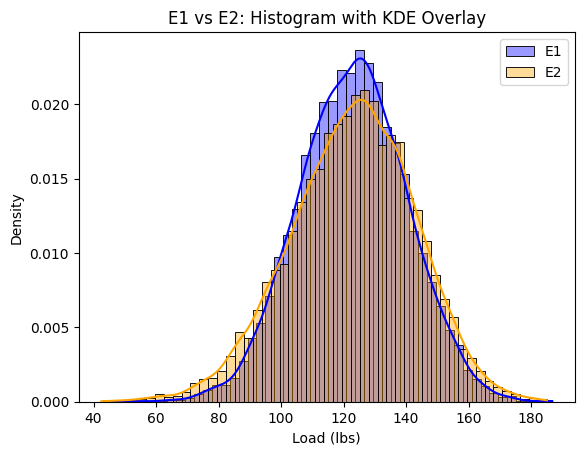

In [43]:
sns.histplot(
    E1_values, label="E1", color="blue", bins=50, kde=True, stat="density", alpha=0.4
)
sns.histplot(
    E2_values, label="E2", color="orange", bins=50, kde=True, stat="density", alpha=0.4
)

plt.title("E1 vs E2: Histogram with KDE Overlay")
plt.xlabel("Load (lbs)")
plt.ylabel("Density")
plt.legend()
plt.show()

In [44]:
print(f"Simulated 10,000 sets of normally distributed samples with size {n}:")

E1_mean = E1_values.mean()
E2_mean = E2_values.mean()

E1_median = np.median(E1_values)
E2_median = np.median(E2_values)

E1_stddev = E1_values.std(ddof=1)
E2_stddev = E2_values.std(ddof=1)

print("\nE1:")
print(f"\tMean:\t{E1_mean:.2f}")
print(f"\tMedian:\t{E1_median:.2f}")
print(f"\tStddev:\t{E1_stddev:.2f}")

print("\nE2:")
print(f"\tMean:\t{E2_mean:.2f}")
print(f"\tMedian:\t{E2_median:.2f}")
print(f"\tStddev:\t{E2_stddev:.2f}")

Simulated 10,000 sets of normally distributed samples with size 14:

E1:
	Mean:	122.88
	Median:	123.15
	Stddev:	17.20

E2:
	Mean:	122.86
	Median:	123.76
	Stddev:	19.94


# Calculate true 10th Percentile

$$
\theta = \bar{x} - 1.28 \cdot s
$$

In [45]:
true_10th_percentile = sample_mean - 1.28 * sample_stddev
print(f"True 10th Percentile: {true_10th_percentile:.2f}")

True 10th Percentile: 121.56


# Estimate Bias & MSE

$$
\text{Bias}(\hat{\theta}) = \mathbb{E}[\hat{\theta}] - \theta
$$

$$
\text{MSE}(\hat{\theta}) = \mathbb{E}\left[ (\hat{\theta} - \theta)^2 \right]
$$

$$
\text{MSE}(\hat{\theta}) = \text{Var}(\hat{\theta}) + \left( \text{Bias}(\hat{\theta}) \right)^2
$$

In [46]:
# Bias
E1_bias = E1_values.mean() - true_10th_percentile
E2_bias = E2_values.mean() - true_10th_percentile

# MSE
E1_mse = np.mean((E1_values - true_10th_percentile) ** 2)
E2_mse = np.mean((E2_values - true_10th_percentile) ** 2)

print("E1:")
print(f"\tBias:\t{E1_bias:.2f}")
print(f"\tMSE:\t{E1_mse:.2f}")

print("\nE2:")
print(f"\tBias:\t{E2_bias:.2f}")
print(f"\tMSE:\t{E2_mse:.2f}")

E1:
	Bias:	1.32
	MSE:	297.63

E2:
	Bias:	1.30
	MSE:	399.25


# Conclusion
### Assuming the data is normally distributed, I would choose **E1** as the estimator for the 10th percentile because it has a lower mean squared error (MSE). 

Although the biases of E1 and E2 are fairly similar, **E2 shows a higher variance**, which negatively affects the overall quality of the estimator. This is reflected in its higher MSE, since the MSE combines both the squared bias and the variance of the estimator.


# Interval

$$
\text{The estimator E1 is reported with a confidence interval constructed as:}
$$

$$
E1 \pm 2 \cdot S1
$$

$$
\text{where S1 is the standard deviation of the estimator E1.}
$$

The multiplier 2 corresponds approximately to the critical value z from the standard normal distribution for a 95\% confidence level, meaning we expect that this interval contains the true 10th percentile about 95\% of the time under repeated sampling.Thus, the confidence interval provides a range of plausible values for the 10th percentile estimate, accounting for sampling variability.

In [47]:
E1_interval = E1_mean - 2 * E1_stddev, E1_mean + 2 * E1_stddev

round(float(E1_interval[0]), 2), round(float(E1_interval[1]), 2)

(88.48, 157.29)

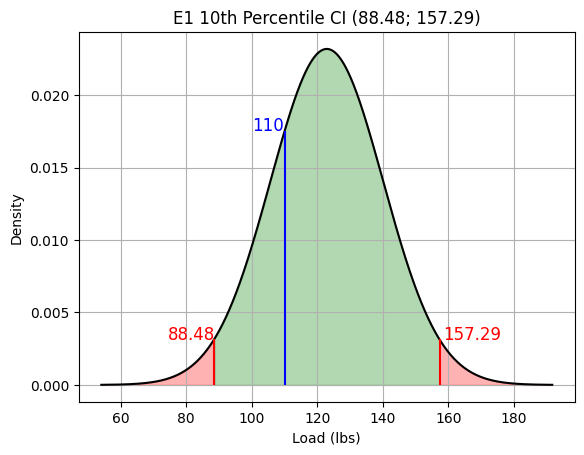

In [48]:
x = np.linspace(E1_mean - 4 * E1_stddev, E1_mean + 4 * E1_stddev, 1000)
y = norm.pdf(x, loc=E1_mean, scale=E1_stddev)

plt.plot(x, y, color="black")

x_fill_left = np.linspace(E1_mean - 4 * E1_stddev, E1_interval[0], 250)
x_fill_middle = np.linspace(E1_interval[0], E1_interval[1], 500)
x_fill_right = np.linspace(E1_interval[1], E1_mean + 4 * E1_stddev, 250)

pdf_fill_left = norm.pdf(x_fill_left, loc=E1_mean, scale=E1_stddev)
pdf_fill_middle = norm.pdf(x_fill_middle, loc=E1_mean, scale=E1_stddev)
pdf_fill_right = norm.pdf(x_fill_right, loc=E1_mean, scale=E1_stddev)

plt.fill_between(x_fill_left, pdf_fill_left, alpha=0.3, color="red")
plt.fill_between(x_fill_middle, pdf_fill_middle, alpha=0.3, color="green")
plt.fill_between(x_fill_right, pdf_fill_right, alpha=0.3, color="red")


plt.vlines(110, 0, norm.pdf(110, loc=E1_mean, scale=E1_stddev), color="blue")

plt.vlines(
    E1_interval[0],
    0,
    norm.pdf(E1_interval[0], loc=E1_mean, scale=E1_stddev),
    color="red",
)
plt.vlines(
    E1_interval[1],
    0,
    norm.pdf(E1_interval[1], loc=E1_mean, scale=E1_stddev),
    color="red",
)

plt.text(
    110 - 10,
    norm.pdf(110, loc=E1_mean, scale=E1_stddev),
    "110",
    color="blue",
    fontsize=12,
)

plt.text(
    E1_interval[0] - 14,
    norm.pdf(E1_interval[0], loc=E1_mean, scale=E1_stddev),
    f"{E1_interval[0]:.2f}",
    color="red",
    fontsize=12,
)
plt.text(
    E1_interval[1] + 1,
    norm.pdf(E1_interval[1], loc=E1_mean, scale=E1_stddev),
    f"{E1_interval[1]:.2f}",
    color="red",
    fontsize=12,
)

plt.title(f"E1 10th Percentile CI ({E1_interval[0]:.2f}; {E1_interval[1]:.2f})")
plt.xlabel("Load (lbs)")
plt.ylabel("Density")
plt.grid()

plt.show()

# Decision (maybe has to be adjusted after removing outliers)

- The interval isn't completely above 110 lbs -> can't be 90% confident my brushes will not fail at 110 lbs
- Interval isn't completely below 110 lbs -> It isn't quite clear that my brushes fail at 110 lbs

### -> Collect more data since the estimate from based on the data probably has too much error to make a conclusive decision. With more data the spread of the estimators will decrease and therefore there is a good chance the interval will go completely above 110